In [1]:
from climpyrical.data import read_data
from climpyrical.mask import stratify_coords

from pkg_resources import resource_filename

import config
import pickle

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

In [2]:
# Parameters cell

In [3]:
# Parameters
name = "TJul97.5"
station_dv = "TJul2.5 (degC)"
station_path = "data/station_inputs/julT97.5p_allstations_v3_min8yr_for_maps.csv"
input_model_path = (
    "data/model_inputs/tas_CanRCM4-LE_ens35_1951-2016_1hr_jul97.5p_ensmean.nc"
)
medians = {"value": 28, "action": "add"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"


In [4]:
# custom plot and reference dictionary
lmap = ['#B544A6', '#884DB2', '#5856AF', '#6089AC', '#6AA8A2', '#64AE90', '#62B07A', '#75B85B', '#B1BF53', '#C78E4B'][::-1]
custom_cmap = matplotlib.colors.ListedColormap(lmap)

plot_dict = {
    'RL50 (kPa)': (custom_cmap, True, 2),
    'mean RH (%)': (custom_cmap, False, 1),
    'HDD (degC-day)': ('RdBu', False, 0),
    'SL50 (kPa)': (custom_cmap, False, 1),
    'WP10 (kPa)': (custom_cmap, False, 2),
    'WP50 (kPa)': (custom_cmap, False, 2),
    'TJan2.5 (degC)': ('RdBu_r', False, 1),
    'TJan1.0 (degC)': ('RdBu_r', False, 1),
    'Tmin (degC)': ('RdBu_r', False, 1),
    'Tmax (degC)': ('RdBu_r', False, 1),
    'TJul2.5 (degC)': ('RdBu_r', False, 1),
    'TwJul2.5 (degC)': ('RdBu_r', False, 1),
    'annual_rain (mm)': (custom_cmap, True, 0),
    'annual_pr (mm)': (custom_cmap, True, 0),
    'DRWP-RL5 (Pa)': (custom_cmap, False, 0),
    '1day rain RL50 (mm)': (custom_cmap, True, 0),
    'moisture_index': (custom_cmap, False, 2),
    "Gum-LM RL10 (mm)": (custom_cmap, True, 1)
}

Load results

In [5]:
canada_shapefile_path = resource_filename("climpyrical", "data/vectors/canada_final.shp")

model = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
reconstruction = read_data(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    )
)

df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)

(dv, ) = reconstruction.data_vars
canada = gpd.read_file(canada_shapefile_path).geometry

output_figure_path = resource_filename("climpyrical", output_figure_path)

Convert to proper units

In [6]:
# if model[dv].attrs["units"] == "K":
#     df[station_dv] = df[station_dv] - 273.15
#     model[dv] -= 273.15
#     model[dv].attrs["units"] = "degC"

if station_dv != "1day rain RL50 (mm)":
    units = model[dv].attrs["units"]
else:
    units = "mm"


In [7]:
# load coastlines, provinces
X, Y = stratify_coords(canada)
extent = [model.rlon.min(), model.rlon.max(), model.rlat.min(), model.rlat.max()]
cxmin, cxmax, cymin, cymax = (
    canada.bounds.minx.min(),
    canada.bounds.maxx.max(),
    canada.bounds.miny.min(),
    canada.bounds.maxy.max()
)

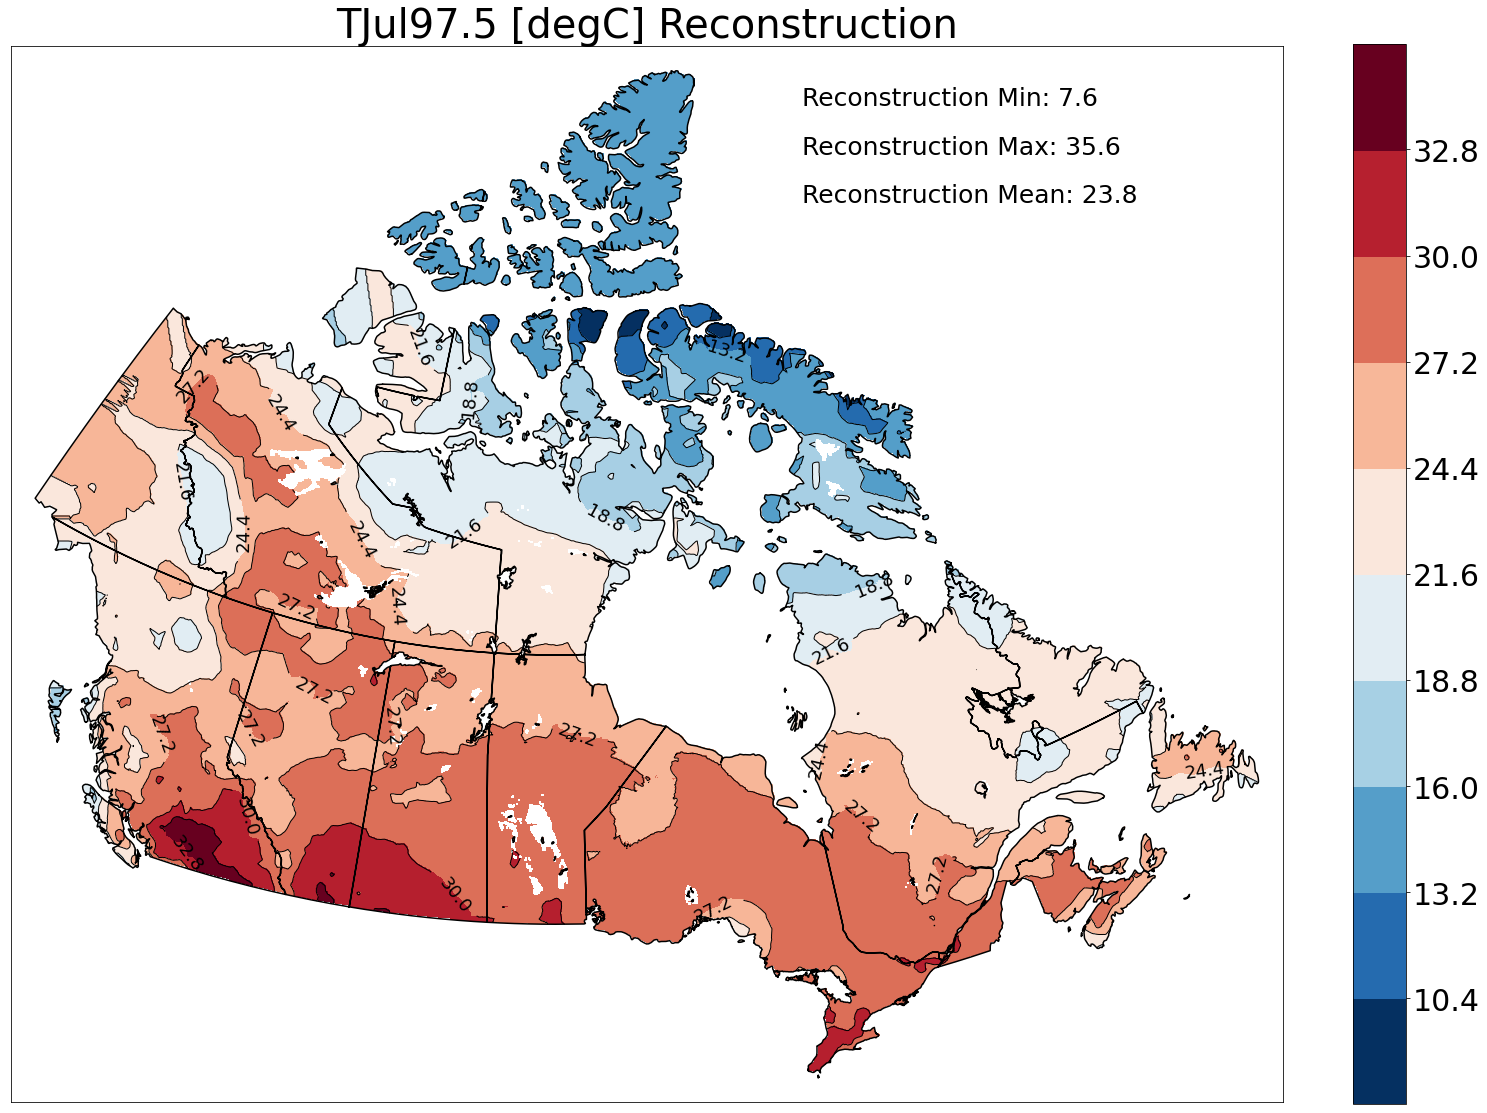

In [8]:
colorscale, log, decimal = plot_dict[station_dv]
N = 10

vmin, vmax = np.nanmin(reconstruction[dv]), np.nanmax(reconstruction[dv])
fig, ax = plt.subplots(figsize=(25, 25))
if not log:
    ticks=np.round(np.linspace(vmin, vmax, N+1), decimals=decimal)
#     ticks=np.linspace(vmin, vmax, N+1)
    col1 = ax.imshow(
        reconstruction[dv], 
        origin='lower', 
        extent=extent, 
        vmin=vmin, 
        vmax=vmax, 
        cmap = matplotlib.cm.get_cmap(colorscale, N)
    )
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks=ticks, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

if log:
#     ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks_lin = ticks.copy()
    ticks = np.round([10**exponent for exponent in ticks], decimal)

    col1 = ax.imshow(
        np.log10(reconstruction[dv]), 
        origin='lower', 
        extent=extent, 
        vmin=ticks_lin.min(),
        vmax=ticks_lin.max(),
        cmap = matplotlib.cm.get_cmap(colorscale, N)    )
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks = ticks_lin, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

CS = ax.contour(
    reconstruction.rlon,
    reconstruction.rlat,
    reconstruction[dv],
    ticks,
    colors='black',
    linewidths=1,
    zorder=4
)
ax.clabel(CS, fontsize=18, inline=1, fmt=f'%1.{decimal}f')
cbar.ax.tick_params(labelsize=30)

if decimal == 0:
    ax.text(10, 35, f'Reconstruction Min: {np.round(np.nanmin(reconstruction[dv]), decimal):.0f}', fontsize=25)
    ax.text(10, 33, f'Reconstruction Max: {np.round(np.nanmax(reconstruction[dv]), decimal):.0f}', fontsize=25)
    ax.text(10, 31, f'Reconstruction Mean: {np.round(np.nanmean(reconstruction[dv]), decimal):.0f}', fontsize=25)
else:
    ax.text(10, 35, f'Reconstruction Min: {np.round(np.nanmin(reconstruction[dv]), decimal)}', fontsize=25)
    ax.text(10, 33, f'Reconstruction Max: {np.round(np.nanmax(reconstruction[dv]), decimal)}', fontsize=25)
    ax.text(10, 31, f'Reconstruction Mean: {np.round(np.nanmean(reconstruction[dv]), decimal)}', fontsize=25)

ax.set_title(
    f'{name} [{units}] Reconstruction',
    fontsize=40
)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)


# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.plot(X, Y, color='black')
with open("reconstrucion.pickle", "wb") as f:
    pickle.dump(ax, f)

plt.savefig(f'{output_figure_path}{name}_reconstruction.png', dpi=150)
plt.show()

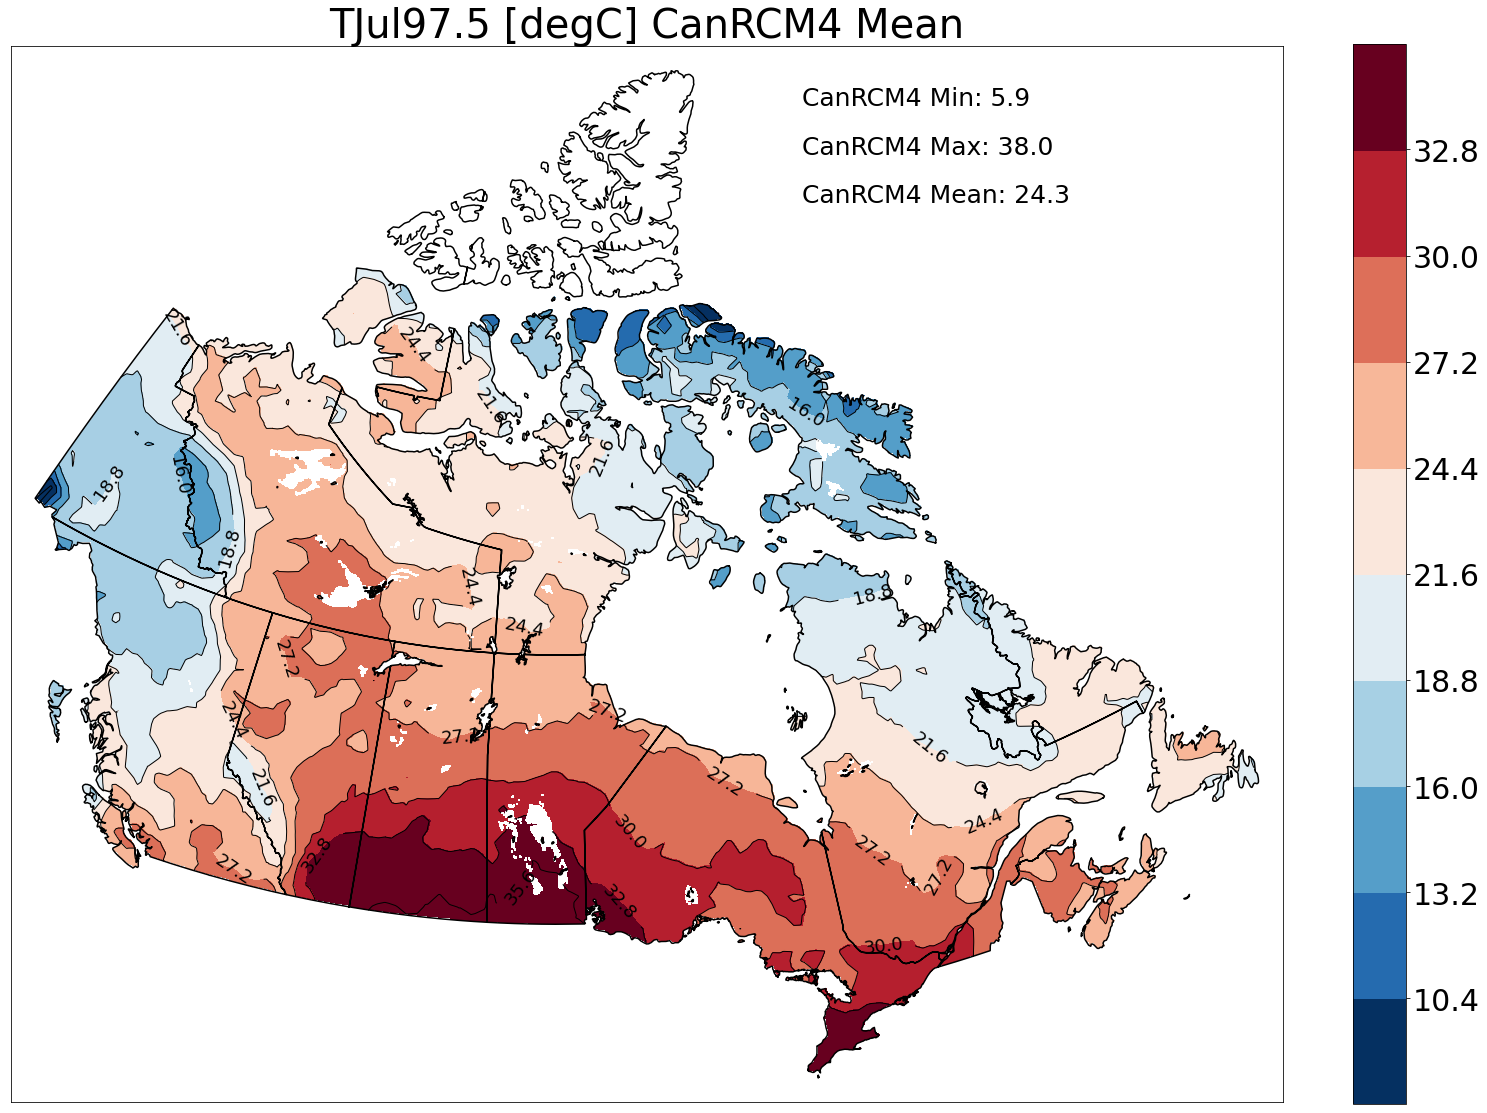

In [9]:
fig, ax = plt.subplots(figsize=(25, 25))

if not log:
    ticks=np.round(np.linspace(vmin, vmax, N+1), decimals=decimal)
#     ticks=np.linspace(vmin, vmax, N+1)
    col1 = ax.imshow(
        model[dv], 
        origin='lower', 
        extent=extent, 
        vmin=vmin, 
        vmax=vmax, 
        cmap = matplotlib.cm.get_cmap(colorscale, N)
    )
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks=ticks, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

if log:
#     ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks_lin = ticks.copy()
    ticks = np.round([10**exponent for exponent in ticks], decimal)

    col1 = ax.imshow(
        np.log10(model[dv]), 
        origin='lower', 
        extent=extent, 
        vmin=ticks_lin.min(),
        vmax=ticks_lin.max(),
        cmap = matplotlib.cm.get_cmap(colorscale, N)
    )
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks = ticks_lin, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

CS = ax.contour(
    model.rlon,
    model.rlat,
    model[dv],
    ticks,
    colors='black',
    linewidths=1,
    zorder=4
)
ax.clabel(CS, fontsize=18, inline=1, fmt=f'%1.{decimal}f')
cbar.ax.tick_params(labelsize=30)

if decimal == 0:
    ax.text(10, 35, f'CanRCM4 Min: {np.round(np.nanmin(model[dv]), decimal):.0f}', fontsize=25)
    ax.text(10, 33, f'CanRCM4 Max: {np.round(np.nanmax(model[dv]), decimal):.0f}', fontsize=25)
    ax.text(10, 31, f'CanRCM4 Mean: {np.round(np.nanmean(model[dv]), decimal):.0f}', fontsize=25)
else:
    ax.text(10, 35, f'CanRCM4 Min: {np.round(np.nanmin(model[dv]), decimal)}', fontsize=25)
    ax.text(10, 33, f'CanRCM4 Max: {np.round(np.nanmax(model[dv]), decimal)}', fontsize=25)
    ax.text(10, 31, f'CanRCM4 Mean: {np.round(np.nanmean(model[dv]), decimal)}', fontsize=25)

ax.set_title(
    f'{name} [{units}] CanRCM4 Mean',
    fontsize=40
)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)


# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.plot(X, Y, color='black')

with open("mean.pickle", "wb") as f:
    pickle.dump(ax, f)
plt.savefig(f'{output_figure_path}{name}_CanRCM4_ensmean.png', dpi=150)
plt.show()

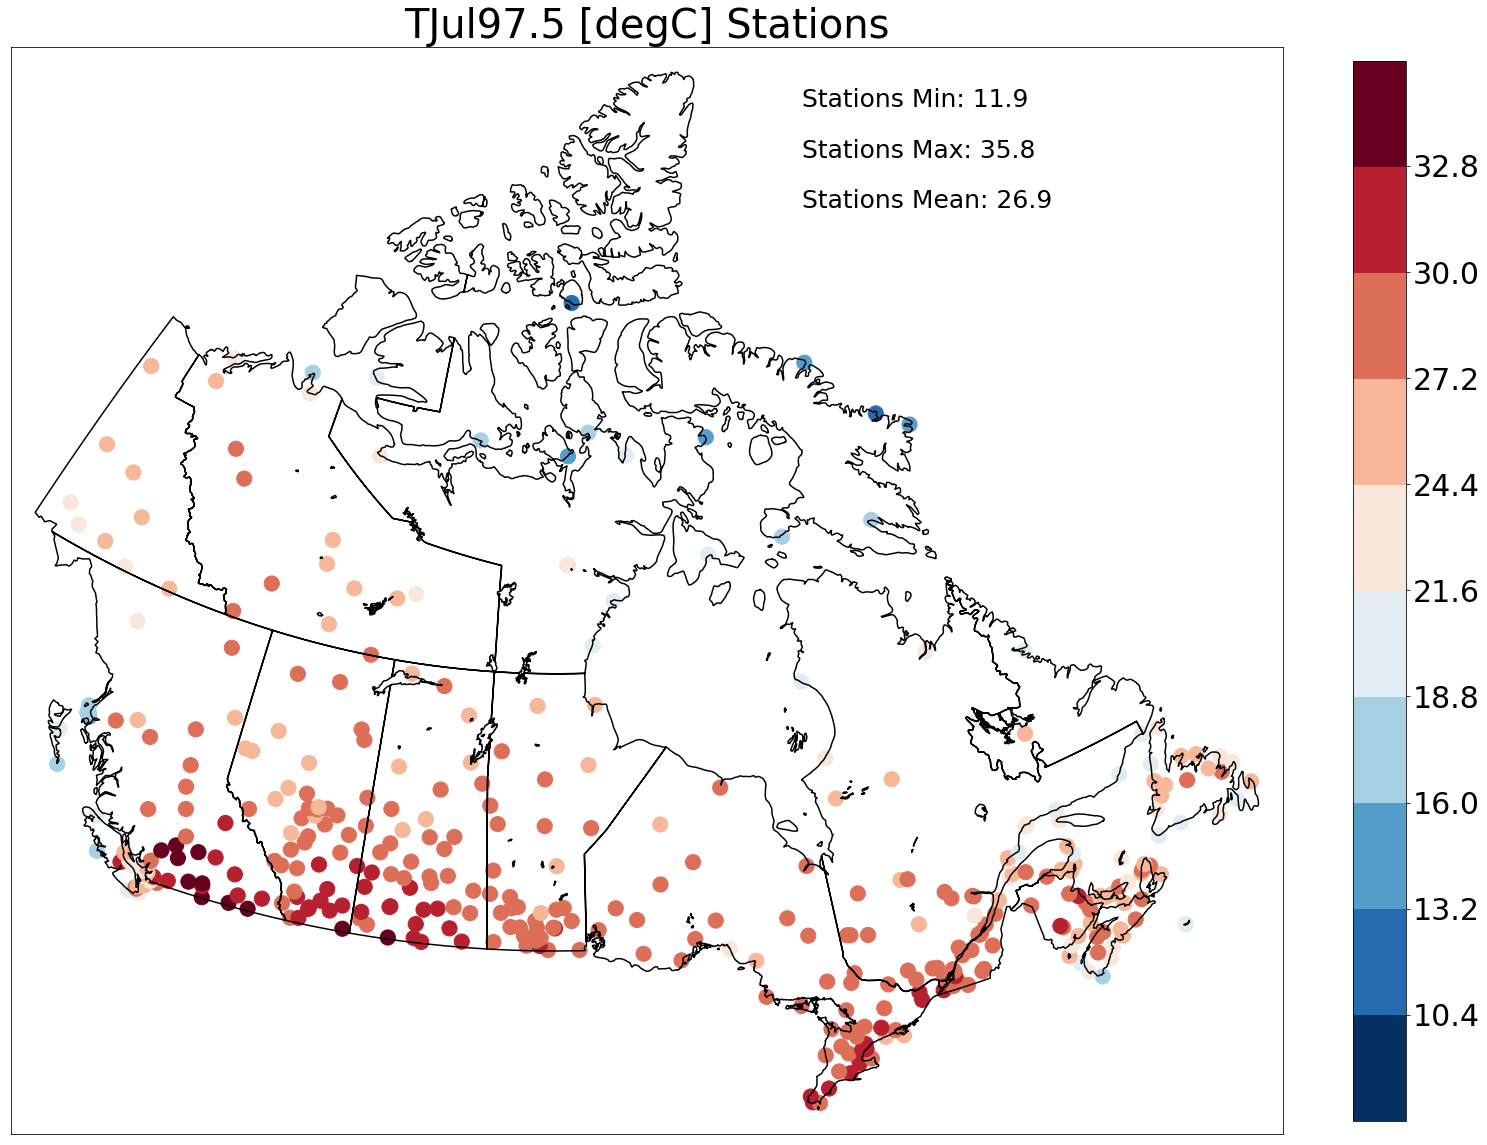

In [10]:
fig, ax = plt.subplots(figsize=(25, 20))

station_vals = df[station_dv].values

if not log:
    ticks=np.round(np.linspace(vmin, vmax, N+1), decimals=decimal)
    col1 = ax.scatter(df.rlon, df.rlat, c = station_vals, s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap(colorscale, N))
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks=ticks, spacing="proportional")

    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

if log:
    ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks_lin = ticks .copy()
    ticks = np.round([10**exponent for exponent in ticks], decimal)
    
    col1 = ax.scatter(df.rlon, df.rlat, c = np.log10(station_vals), s=230, vmin = ticks_lin.min(), vmax = ticks_lin.max(), cmap = plt.cm.get_cmap(colorscale, N))
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks = ticks_lin, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

cbar.ax.tick_params(labelsize=30)

if decimal == 0:
    ax.text(10, 35, f'Stations Min: {np.round(np.nanmin(station_vals), decimal):.0f}', fontsize=25)
    ax.text(10, 33, f'Stations Max: {np.round(np.nanmax(station_vals), decimal):.0f}', fontsize=25)
    ax.text(10, 31, f'Stations Mean: {np.round(np.nanmean(station_vals), decimal):.0f}', fontsize=25)
else:
    ax.text(10, 35, f'Stations Min: {np.round(np.nanmin(station_vals), decimal)}', fontsize=25)
    ax.text(10, 33, f'Stations Max: {np.round(np.nanmax(station_vals), decimal)}', fontsize=25)
    ax.text(10, 31, f'Stations Mean: {np.round(np.nanmean(station_vals), decimal)}', fontsize=25)

    
ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.set_title(f'{name} [{units}] Stations', fontsize=40)
ax.plot(X, Y, color='black')
with open("stations.pickle", "wb") as f:
    pickle.dump(ax, f)
plt.savefig(f"{output_figure_path}{name}_stations.png", dpi = 150)
plt.show()

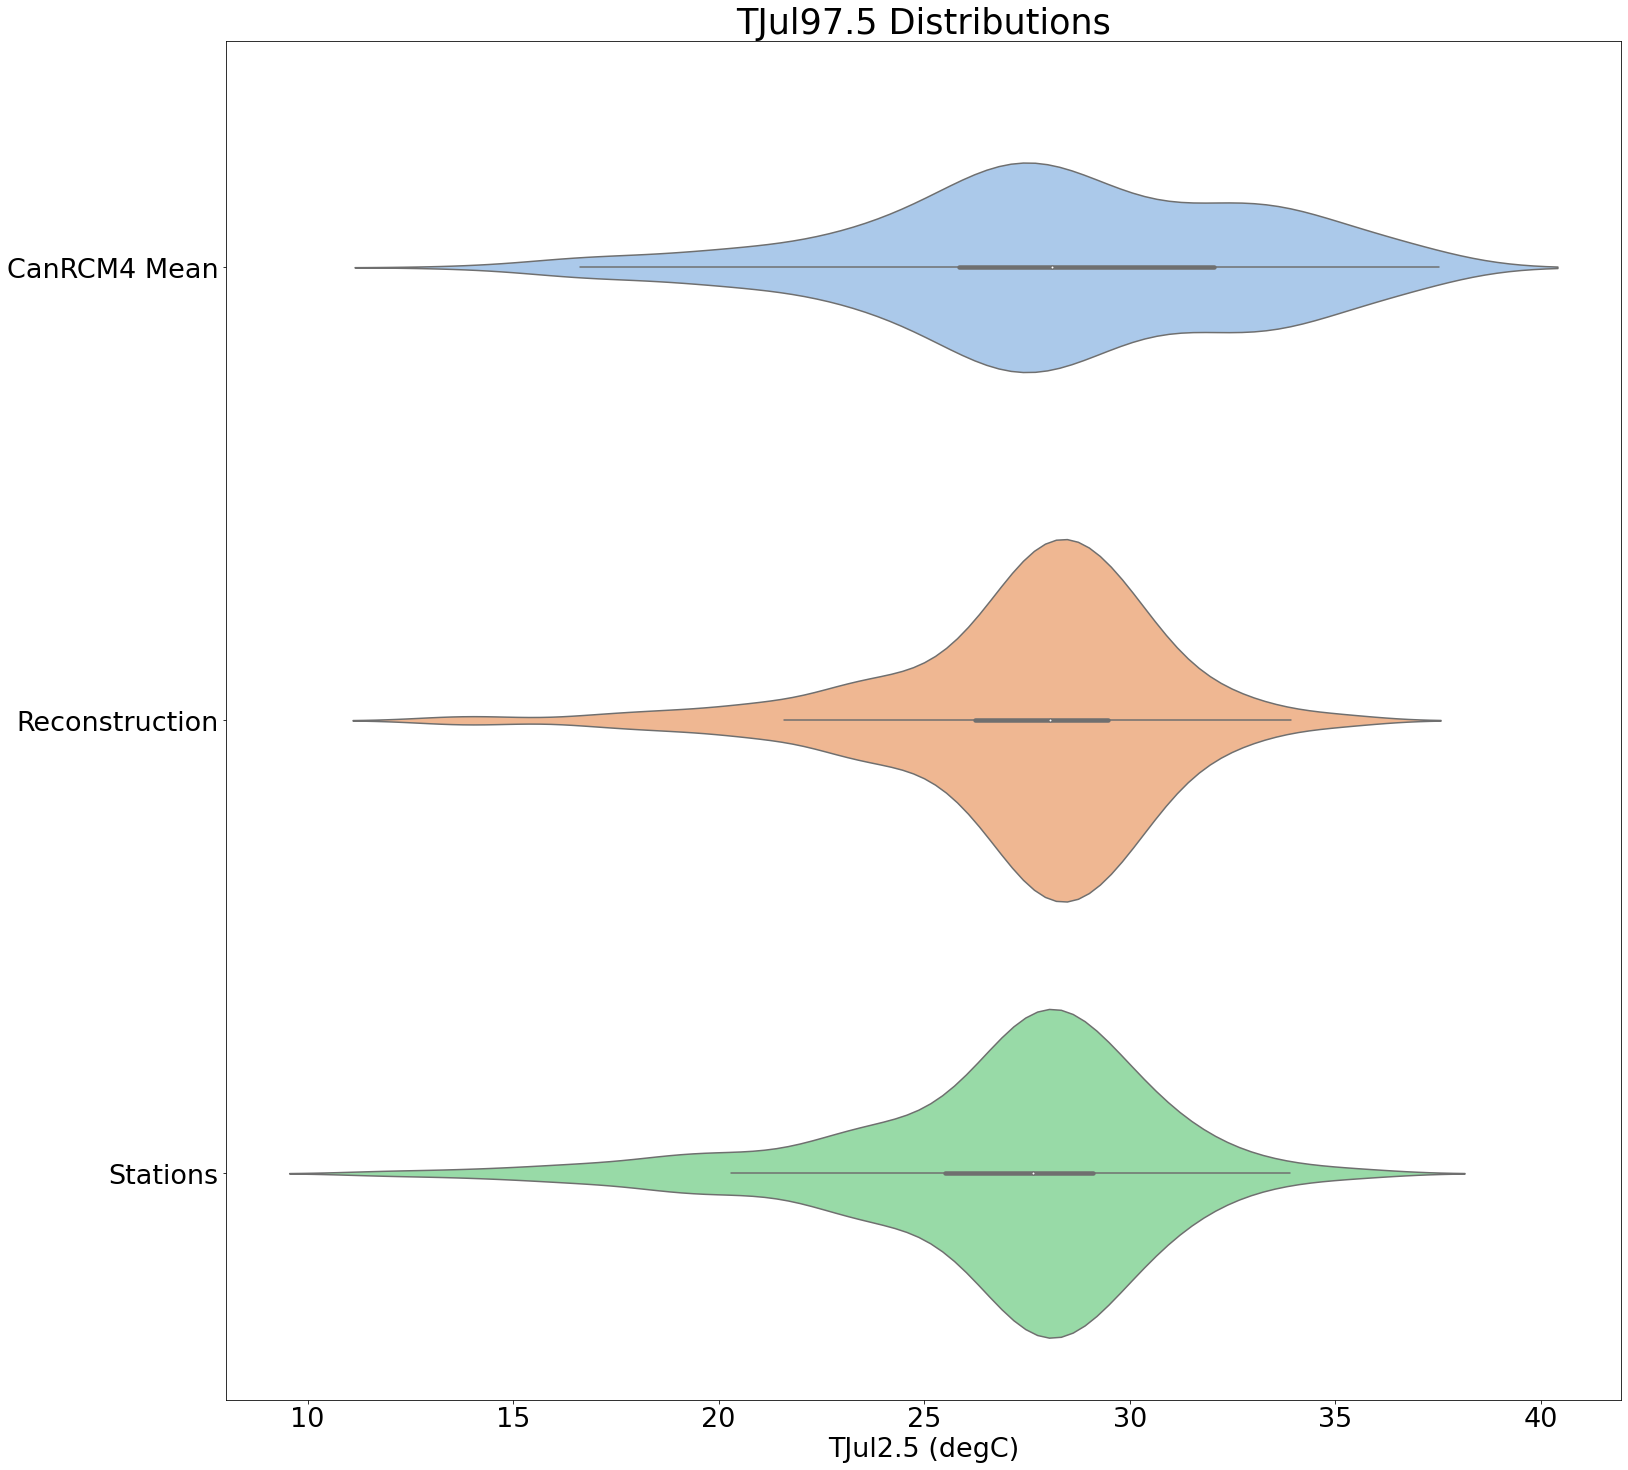

In [11]:
fig, ax = plt.subplots(figsize=(25, 25))

with sns.axes_style("whitegrid"):
    violindata = np.concatenate([model[dv].values[df.irlat, df.irlon].flatten(), reconstruction[dv].values[df.irlat, df.irlon].flatten(), station_vals])
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))


    means_str = ["CanRCM4 Mean" for x in model[dv].values[df.irlat, df.irlon].flatten()]
    ratio_str = ["Reconstruction" for x in reconstruction[dv].values[df.irlat, df.irlon].flatten()]
    station_str = ["Stations" for x in station_vals]

    vstrings = np.concatenate([means_str, ratio_str, station_str])

    vdf = pd.DataFrame({station_dv: violindata, '': vstrings})

    ax.set_title(f"{name} Distributions", fontsize=35)
    vp = sns.violinplot(ax=ax, x=station_dv, y='', data=vdf, palette=sns.color_palette('pastel'))
    vp.tick_params(labelsize=27)
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=27)

plt.savefig(f'{output_figure_path}{name}_dist.png', bbox_inches='tight', dpi = 150)

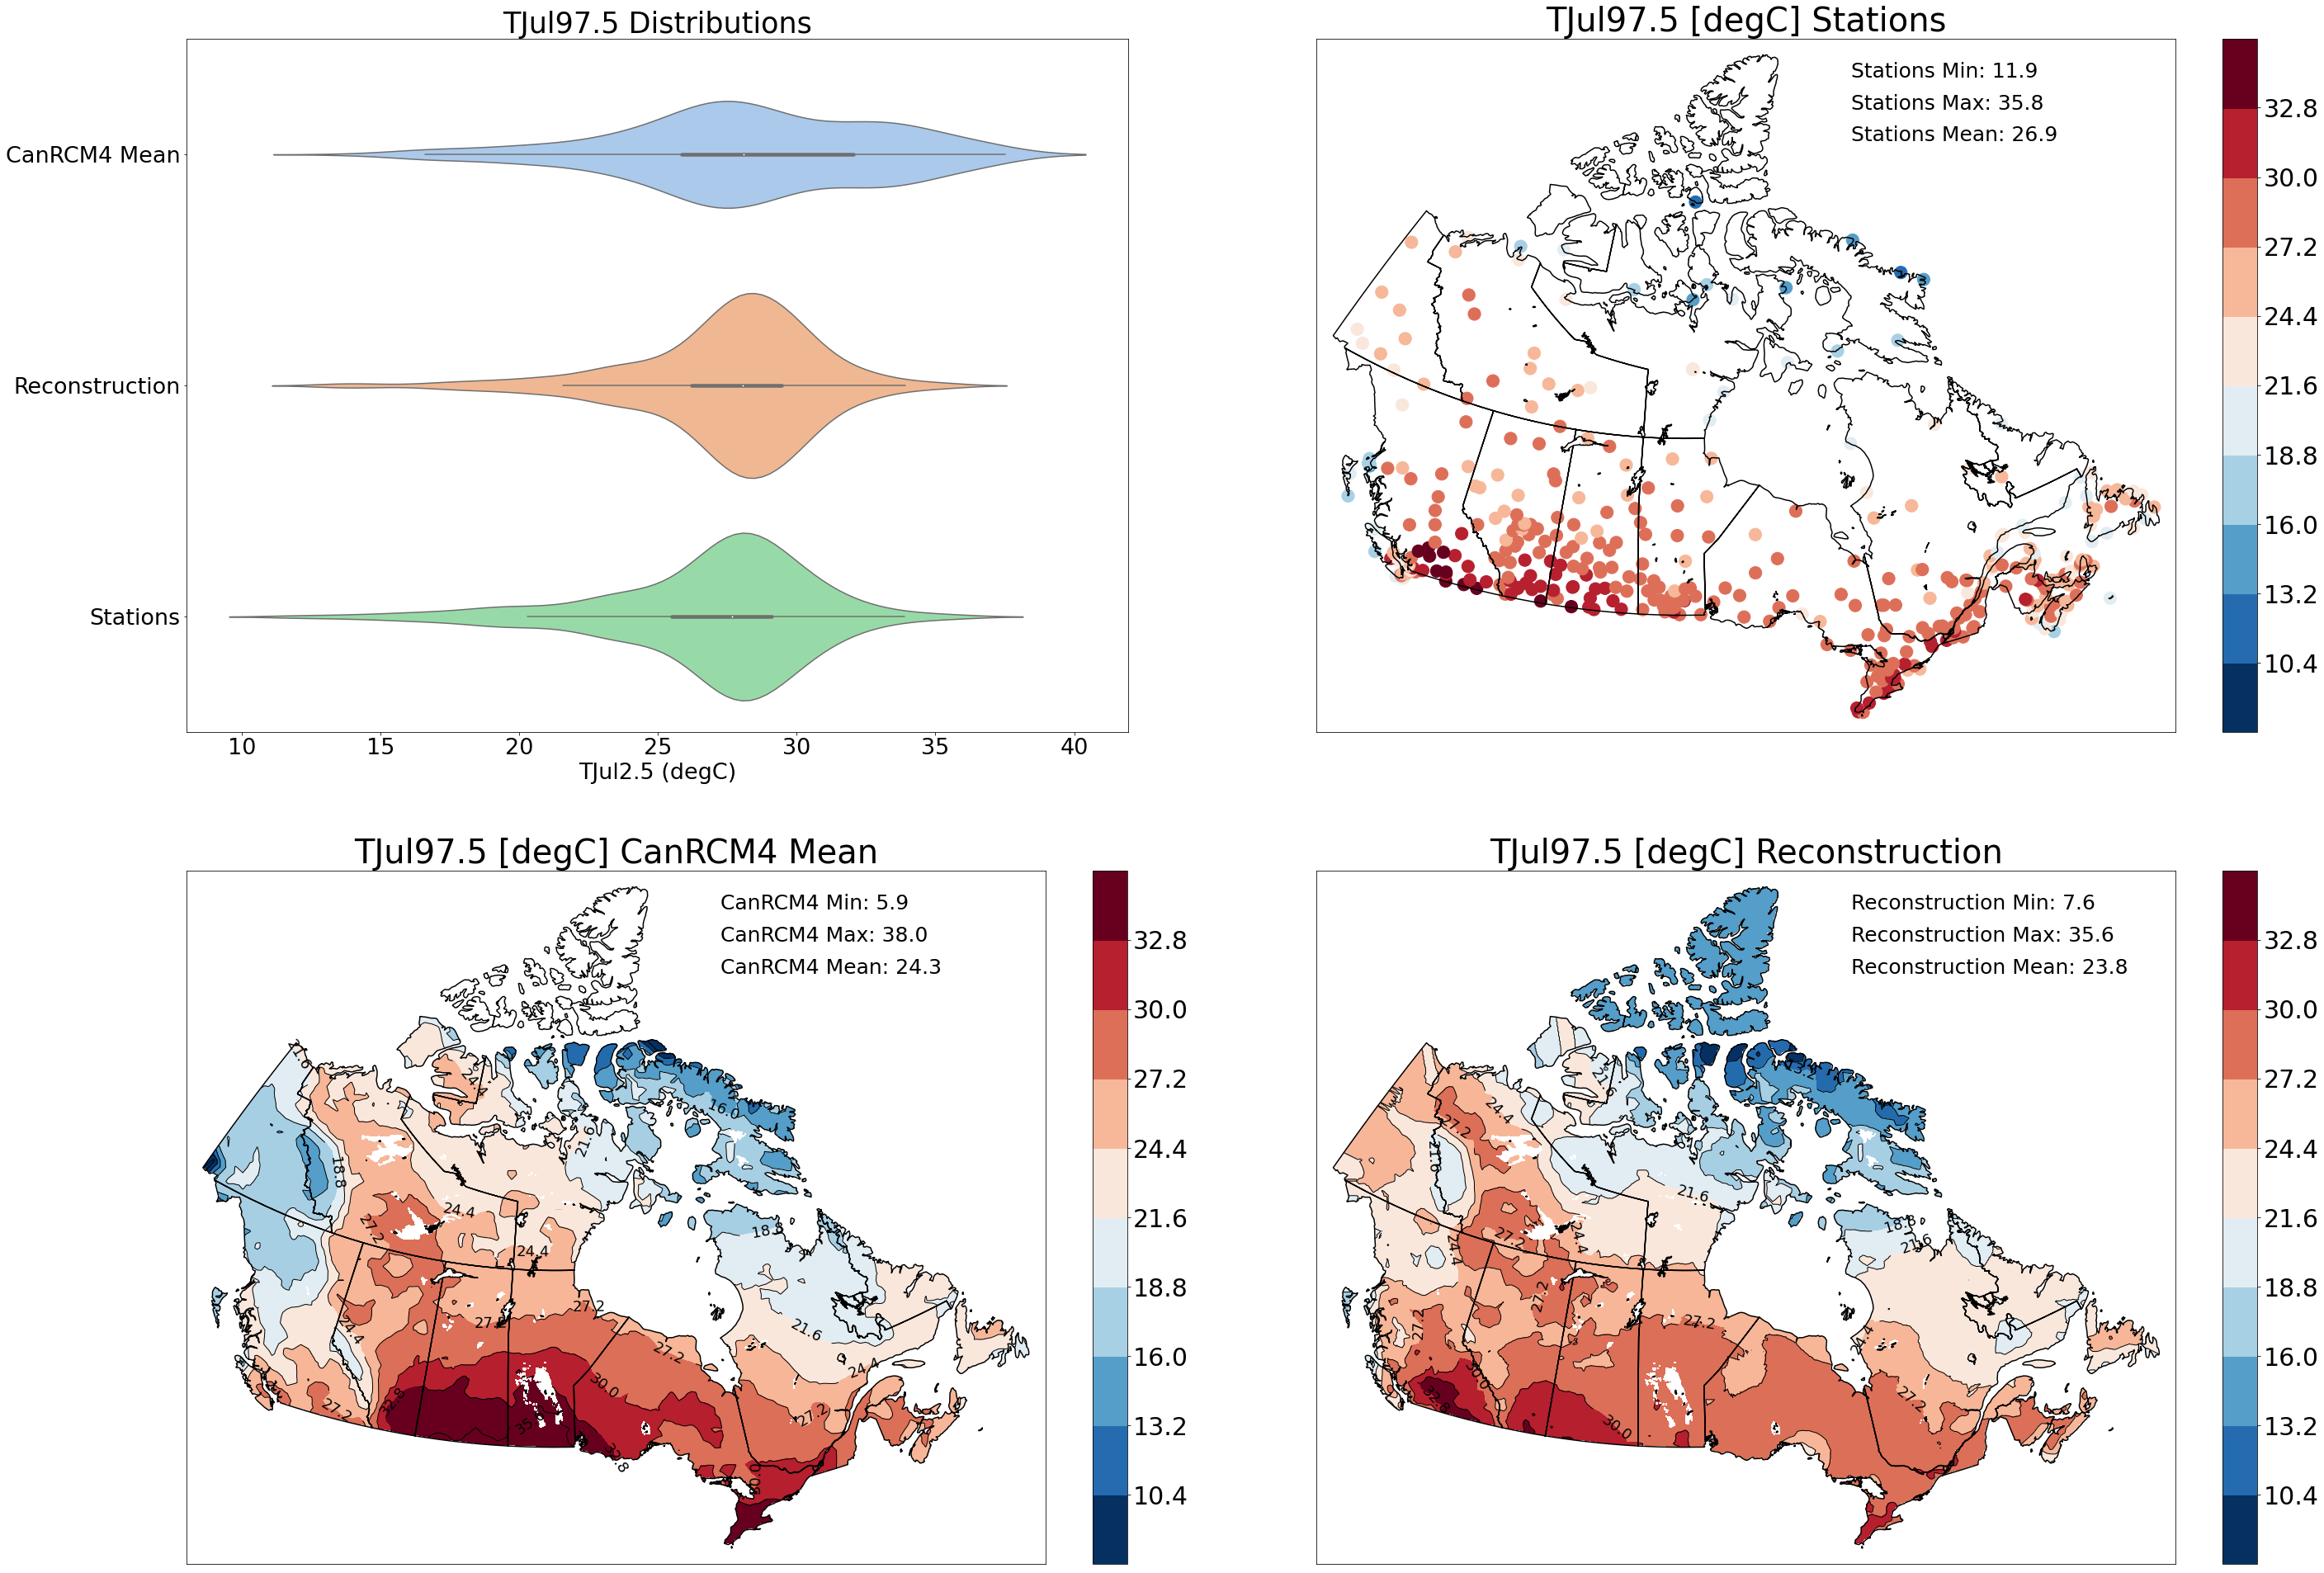

In [12]:
# MASSIVE CELL FOR SUBPLOTS. SORRY!
fig, ax = plt.subplots(2, 2, gridspec_kw={'height_ratios': [0.6, 0.6]}, figsize=(45, 34))

if not log:
    ticks=np.round(np.linspace(vmin, vmax, N+1), decimals=decimal)
    col1 = ax[1, 1].imshow(
        reconstruction[dv], 
        origin='lower', 
        extent=extent, 
        vmin=vmin, 
        vmax=vmax, 
        cmap = matplotlib.cm.get_cmap(colorscale, N), aspect="auto"
    )
    cbar = plt.colorbar(col1, ax = ax[1, 1], fraction=0.038, pad=0.05, ticks=ticks, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

if log:
#     ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks_lin = ticks.copy()
    ticks = np.round([10**exponent for exponent in ticks], decimal)

    col1 = ax[1, 1].imshow(
        np.log10(reconstruction[dv]), 
        origin='lower', 
        extent=extent, 
        vmin=ticks_lin.min(),
        vmax=ticks_lin.max(),
        cmap = matplotlib.cm.get_cmap(colorscale, N), aspect="auto"
    )
    cbar = plt.colorbar(col1, ax = ax[1, 1], fraction=0.038, pad=0.05, ticks = ticks_lin, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

CS = ax[1, 1].contour(
    reconstruction.rlon,
    reconstruction.rlat,
    reconstruction[dv],
    ticks,
    colors='black',
    linewidths=1,
    zorder=4
)
ax[1, 1].clabel(CS, fontsize=18, inline=1, fmt=f'%1.{decimal}f')
cbar.ax.tick_params(labelsize=30)

if decimal == 0:
    ax[1, 1].text(10, 35, f'Reconstruction Min: {np.round(np.nanmin(reconstruction[dv]), decimal):.0f}', fontsize=25)
    ax[1, 1].text(10, 33, f'Reconstruction Max: {np.round(np.nanmax(reconstruction[dv]), decimal):.0f}', fontsize=25)
    ax[1, 1].text(10, 31, f'Reconstruction Mean: {np.round(np.nanmean(reconstruction[dv]), decimal):.0f}', fontsize=25)
else:
    ax[1, 1].text(10, 35, f'Reconstruction Min: {np.round(np.nanmin(reconstruction[dv]), decimal)}', fontsize=25)
    ax[1, 1].text(10, 33, f'Reconstruction Max: {np.round(np.nanmax(reconstruction[dv]), decimal)}', fontsize=25)
    ax[1, 1].text(10, 31, f'Reconstruction Mean: {np.round(np.nanmean(reconstruction[dv]), decimal)}', fontsize=25)

ax[1, 1].set_title(
    f'{name} [{units}] Reconstruction',
    fontsize=40
)

ax[1, 1].set_xlim(cxmin-1, cxmax+1)
ax[1, 1].set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax[1, 1].grid(False)


# Hide axes ticks
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

ax[1, 1].plot(X, Y, color='black')

################### MEAN ######################################

if not log:
    ticks=np.round(np.linspace(vmin, vmax, N+1), decimals=decimal)
#     ticks=np.linspace(vmin, vmax, N+1)
    col1 = ax[1, 0].imshow(
        model[dv], 
        origin='lower', 
        extent=extent, 
        vmin=vmin, 
        vmax=vmax, 
        cmap = matplotlib.cm.get_cmap(colorscale, N), aspect="auto"
    )
    cbar = plt.colorbar(col1, ax = ax[1, 0], fraction=0.038, pad=0.05, ticks=ticks, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

if log:
#     ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks_lin = ticks.copy()
    ticks = np.round([10**exponent for exponent in ticks], decimal)

    col1 = ax[1, 0].imshow(
        np.log10(model[dv]), 
        origin='lower', 
        extent=extent, 
        vmin=ticks_lin.min(),
        vmax=ticks_lin.max(),
        cmap = matplotlib.cm.get_cmap(colorscale, N), aspect="auto"
    )
    cbar = plt.colorbar(col1, ax = ax[1, 0], fraction=0.038, pad=0.05, ticks = ticks_lin, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

CS = ax[1, 0].contour(
    model.rlon,
    model.rlat,
    model[dv],
    ticks,
    colors='black',
    linewidths=1,
    zorder=4
)
ax[1, 0].clabel(CS, fontsize=18, inline=1, fmt=f'%1.{decimal}f')
cbar.ax.tick_params(labelsize=30)

if decimal == 0:
    ax[1, 0].text(10, 35, f'CanRCM4 Min: {np.round(np.nanmin(model[dv]), decimal):.0f}', fontsize=25)
    ax[1, 0].text(10, 33, f'CanRCM4 Max: {np.round(np.nanmax(model[dv]), decimal):.0f}', fontsize=25)
    ax[1, 0].text(10, 31, f'CanRCM4 Mean: {np.round(np.nanmean(model[dv]), decimal):.0f}', fontsize=25)
else:
    ax[1, 0].text(10, 35, f'CanRCM4 Min: {np.round(np.nanmin(model[dv]), decimal)}', fontsize=25)
    ax[1, 0].text(10, 33, f'CanRCM4 Max: {np.round(np.nanmax(model[dv]), decimal)}', fontsize=25)
    ax[1, 0].text(10, 31, f'CanRCM4 Mean: {np.round(np.nanmean(model[dv]), decimal)}', fontsize=25)

ax[1, 0].set_title(
    f'{name} [{units}] CanRCM4 Mean',
    fontsize=40
)

ax[1, 0].set_xlim(cxmin-1, cxmax+1)
ax[1, 0].set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax[1, 0].grid(False)


# Hide axes ticks
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 0].plot(X, Y, color='black')

################# STATIONS ###############################
if not log:
    ticks=np.round(np.linspace(vmin, vmax, N+1), decimals=decimal)
    col1 = ax[0, 1].scatter(df.rlon, df.rlat, c = station_vals, s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap(colorscale, N))
    cbar = plt.colorbar(col1, ax = ax[0, 1], fraction=0.038, pad=0.05, ticks=ticks, spacing="proportional")

    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

if log:
    ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks_lin = ticks .copy()
    ticks = np.round([10**exponent for exponent in ticks], decimal)
    
    col1 = ax[0, 1].scatter(df.rlon, df.rlat, c = np.log10(station_vals), s=230, vmin = ticks_lin.min(), vmax = ticks_lin.max(), cmap = plt.cm.get_cmap(colorscale, N))
    cbar = plt.colorbar(col1, ax = ax[0, 1], fraction=0.038, pad=0.05, ticks = ticks_lin, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

cbar.ax.tick_params(labelsize=30)

if decimal == 0:
    ax[0, 1].text(10, 35, f'Stations Min: {np.round(np.nanmin(station_vals), decimal):.0f}', fontsize=25)
    ax[0, 1].text(10, 33, f'Stations Max: {np.round(np.nanmax(station_vals), decimal):.0f}', fontsize=25)
    ax[0, 1].text(10, 31, f'Stations Mean: {np.round(np.nanmean(station_vals), decimal):.0f}', fontsize=25)
else:
    ax[0, 1].text(10, 35, f'Stations Min: {np.round(np.nanmin(station_vals), decimal)}', fontsize=25)
    ax[0, 1].text(10, 33, f'Stations Max: {np.round(np.nanmax(station_vals), decimal)}', fontsize=25)
    ax[0, 1].text(10, 31, f'Stations Mean: {np.round(np.nanmean(station_vals), decimal)}', fontsize=25)

    
ax[0, 1].set_xlim(cxmin-1, cxmax+1)
ax[0, 1].set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax[0, 1].grid(False)

# Hide axes ticks
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[0, 1].set_title(f'{name} [{units}] Stations', fontsize=40)
ax[0, 1].plot(X, Y, color='black')


################ VIOLIN #########################################
# sns.set_theme(style="whitegrid")
with sns.axes_style("whitegrid"):
    violindata = np.concatenate([model[dv].values[df.irlat, df.irlon].flatten(), reconstruction[dv].values[df.irlat, df.irlon].flatten(), station_vals])
    ax[0, 0].xaxis.set_major_locator(plt.MaxNLocator(8))


    means_str = ["CanRCM4 Mean" for x in model[dv].values[df.irlat, df.irlon].flatten()]
    ratio_str = ["Reconstruction" for x in reconstruction[dv].values[df.irlat, df.irlon].flatten()]
    station_str = ["Stations" for x in station_vals]

    vstrings = np.concatenate([means_str, ratio_str, station_str])

    vdf = pd.DataFrame({station_dv: violindata, '': vstrings})

    ax[0, 0].set_title(f"{name} Distributions", fontsize=35)
    vp = sns.violinplot(ax=ax[0, 0], x=station_dv, y='', data=vdf, palette=sns.color_palette('pastel'))
    vp.tick_params(labelsize=27)
    l = ax[0, 0].get_xlabel()
    ax[0, 0].set_xlabel(l, fontsize=27)


    # plt.tight_layout()
plt.savefig(f'{output_figure_path}{name}_panel.png', bbox_inches='tight', dpi = 150)